## DS 6050 Final Project
### NFL Heel and Toe Key Point Estimation
Arjun Ganesh (avg3xt), Nick Landi (nyl4gw), Elizabeth Lee (ewl3dv), Anahita Sharma (ahs3zq)


---



#### Loading in Modules

In [1]:
!pip install labelbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 172 kB 7.5 MB/s 


In [2]:
### YOLOv5
import torch
import cv2
from google.colab.patches import cv2_imshow 
from PIL import Image


# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev

  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
import numpy as np
import pandas as pd
import os
from labelbox import Client, Label
import json
import random

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

# from imgaug.augmentables.kps import KeypointsOnImage
# from imgaug.augmentables.kps import Keypoint
# import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

#### Connecting to data source 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd "/content/gdrive/MyDrive/DS 6050: NFL Final Project"

/content/gdrive/.shortcut-targets-by-id/1xSsipNbN8g5P3wju3q5pR2i3MxyVBUg6/DS 6050: NFL Final Project


#### Data Cleaning

In [ ]:
data = pd.read_json("deeplearning_merged_data.json")

In [ ]:
data.head()

,ID,DataRow ID,Labeled Data,Label,Created By,...,Dataset Name,Reviews,View Label,Has Open Issues,Skipped
0,cl20wxeak0o0x0z8fde1p0hg3,cl20wu59000150zt17dal0q13,https://storage.labelbox.com/cl20wdn770n3f0z9r...,{'objects': [{'featureId': 'cl20wxijf00013f6ch...,am7ad@virginia.edu,...,nfl_data_new,[],https://editor.labelbox.com?project=cl20wjm6s0...,0,False
1,cl216zb6907rh0za21j096hyg,cl20wu59000190zt1a0213v9m,https://storage.labelbox.com/cl20wdn770n3f0z9r...,{'objects': [{'featureId': 'cl216zfx900013f6cg...,am7ad@virginia.edu,...,nfl_data_new,[],https://editor.labelbox.com?project=cl20wjm6s0...,0,False
2,cl216zbey0a8910as2ed642gd,cl20wu590001d0zt128nm9ciw,https://storage.labelbox.com/cl20wdn770n3f0z9r...,{'objects': [{'featureId': 'cl21733b0001k3f6cm...,am7ad@virginia.edu,...,nfl_data_new,[],https://editor.labelbox.com?project=cl20wjm6s0...,0,False
3,cl2172o300aal10as1ays7c0d,cl20wu591001h0zt1163j9is9,https://storage.labelbox.com/cl20wdn770n3f0z9r...,{'objects': [{'featureId': 'cl2175idg002q3f6cp...,am7ad@virginia.edu,...,nfl_data_new,[],https://editor.labelbox.com?project=cl20wjm6s0...,0,False
4,cl21759n408220z9e0j0far2k,cl20wu591001l0zt1h7ijcsbq,https://storage.labelbox.com/cl20wdn770n3f0z9r...,{'objects': [{'featureId': 'cl21777c800423f6c9...,am7ad@virginia.edu,...,nfl_data_new,[],https://editor.labelbox.com?project=cl20wjm6s0...,0,False


In [ ]:
data.shape

(1050, 18)

In [ ]:
data = data[data.Skipped == False].reset_index(drop = True)

In [ ]:
data.shape

(1038, 18)

In [ ]:
value_list = []
x_list = []
y_list = []
externalid_list = []

for j in range(0, len(data["External ID"])):
  current_id = data["External ID"][j]
  for i in range(0, len(data["Label"][j]['objects'])):
    x_list.append(data["Label"][j]['objects'][i]['point']['x'])
    y_list.append(data["Label"][j]['objects'][i]['point']['y'])
    externalid_list.append(current_id)
    value_list.append(data["Label"][j]['objects'][i]['value'])

In [ ]:
df = pd.DataFrame({'values':value_list,
              'x':x_list,
              'y':y_list,
              'external_id':externalid_list})

In [ ]:
df['values'].value_counts()

heels    16710
toes     16198
Name: values, dtype: int64

In [ ]:
IMG_DIR = "/content/gdrive/MyDrive/DS 6050: NFL Final Project/dataset"

In [ ]:
df[df['external_id'] == '57507_000161_Sideline_frame552.jpg']

,values,x,y,external_id
0,toes,530.503,517.621,57507_000161_Sideline_frame552.jpg
1,toes,627.704,529.332,57507_000161_Sideline_frame552.jpg
2,toes,256.468,478.975,57507_000161_Sideline_frame552.jpg
3,toes,230.704,448.527,57507_000161_Sideline_frame552.jpg
4,toes,16.395,377.091,57507_000161_Sideline_frame552.jpg
5,toes,399.341,467.264,57507_000161_Sideline_frame552.jpg
6,toes,408.710,423.934,57507_000161_Sideline_frame552.jpg
7,toes,445.014,418.079,57507_000161_Sideline_frame552.jpg
8,toes,514.108,402.855,57507_000161_Sideline_frame552.jpg
9,toes,530.503,413.394,57507_000161_Sideline_frame552.jpg


#### YOLOv5

In [ ]:
import os
def yolo(path):
  im = path

  # Inference
  results = model(im)

  return results.pandas().xyxy[0],im

#image path
%cd "/content/gdrive/MyDrive/DS 6050: NFL Final Project/dataset"

image_names = os.listdir("/content/gdrive/MyDrive/DS 6050: NFL Final Project/dataset")

/content/gdrive/.shortcut-targets-by-id/1xSsipNbN8g5P3wju3q5pR2i3MxyVBUg6/DS 6050: NFL Final Project/dataset


In [ ]:
def get_player(r,im):
  rgb_per_person = []
  for i in range(len(r)):
    img = cv2.imread(im)
    person_rgb = img[int(r["ymin"][i]):int(r["ymax"][i]),int(r["xmin"][i]):int(r["xmax"][i])]
    rgb_per_person.append(person_rgb)
  return rgb_per_person

In [ ]:
[i for i in os.listdir("/content/gdrive/MyDrive/DS 6050: NFL Final Project/dataset/") if i == "model.png"]

[]

In [ ]:
# Cropping images with key points
people_list = []
for i in image_names:
  image, path = yolo("/content/gdrive/MyDrive/DS 6050: NFL Final Project/dataset/"+i)
  image_df = image.query("name == 'person'").reset_index()

  #padding
  image_name = Image.open(i)
  n = 10
  
  image_df['xmin'] = [j-n if j >= n else j for j in image_df["xmin"]]
  image_df['ymin'] = [j-n if j >= n else j for j in image_df["ymin"]]
  image_df['xmax'] = [j+n if j <= image_name.size[1]-n else j for j in image_df["xmax"]]
  image_df['ymax'] = [j+n if j <= image_name.size[0]-n else j for j in image_df["ymax"]]

  rgb_per_person = get_player(image_df,path)

  #add keypoints
  #df is the dataframe for the original coordinates
  temp_df = df[df['external_id'] == i].reset_index()

  for p in range(len(image_df))[0:6]:
    adj_x = []
    adj_y = []
    values = []
    prob = []
    
    for k in range(len(temp_df)):
      if (temp_df['x'][k] <= image_df['xmax'][p]) & (temp_df['x'][k] >= image_df['xmin'][p]) & (temp_df['y'][k] <= image_df['ymax'][p]) & (temp_df['y'][k] >= image_df['ymin'][p]):
        adjustedx = temp_df['x'][k] - image_df['xmin'][p]
        adjustedy = temp_df['y'][k] - image_df['ymin'][p]
        adj_x.append(adjustedx)
        adj_y.append(adjustedy)
        prob.append(1)
        values.append(temp_df["values"][k])
        
    # dictionary: rgb, (xcoord, ycoord), new image name, toe_or_heel
    kps = {'image_data': rgb_per_person[p], 
           'joints': list(zip(adj_x, adj_y, prob, values))}

    if len(kps["joints"]) > 0:
      if len(kps["joints"]) == 4:
        people_list.append(kps)
      elif len(kps["joints"]) > 4:
        kps["joints"] = random.sample(kps["joints"], k=4)
        people_list.append(kps)
      else:
        people_list.append(kps)

In [ ]:
# Number of cropped images
len(people_list)

4538

In [ ]:
keypoint_def = pd.DataFrame({'Name': ["toes", "heels"], "Hex colour": ["d82400", "fcfc00"]})
keypoint_def

,Name,Hex colour
0,toes,d82400
1,heels,fcfc00


In [ ]:
# Extract the colours and labels.
colours = keypoint_def["Hex colour"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = keypoint_def["Name"].values.tolist()

# Getting joints 
def get_joints(name):
    img_data = plt.imread(os.path.join(IMG_DIR, name))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    dict_item = [x for x in dict_list if x["external_id"][0] == name][0]
    dict_item["img_data"] = img_data

    return dict_item

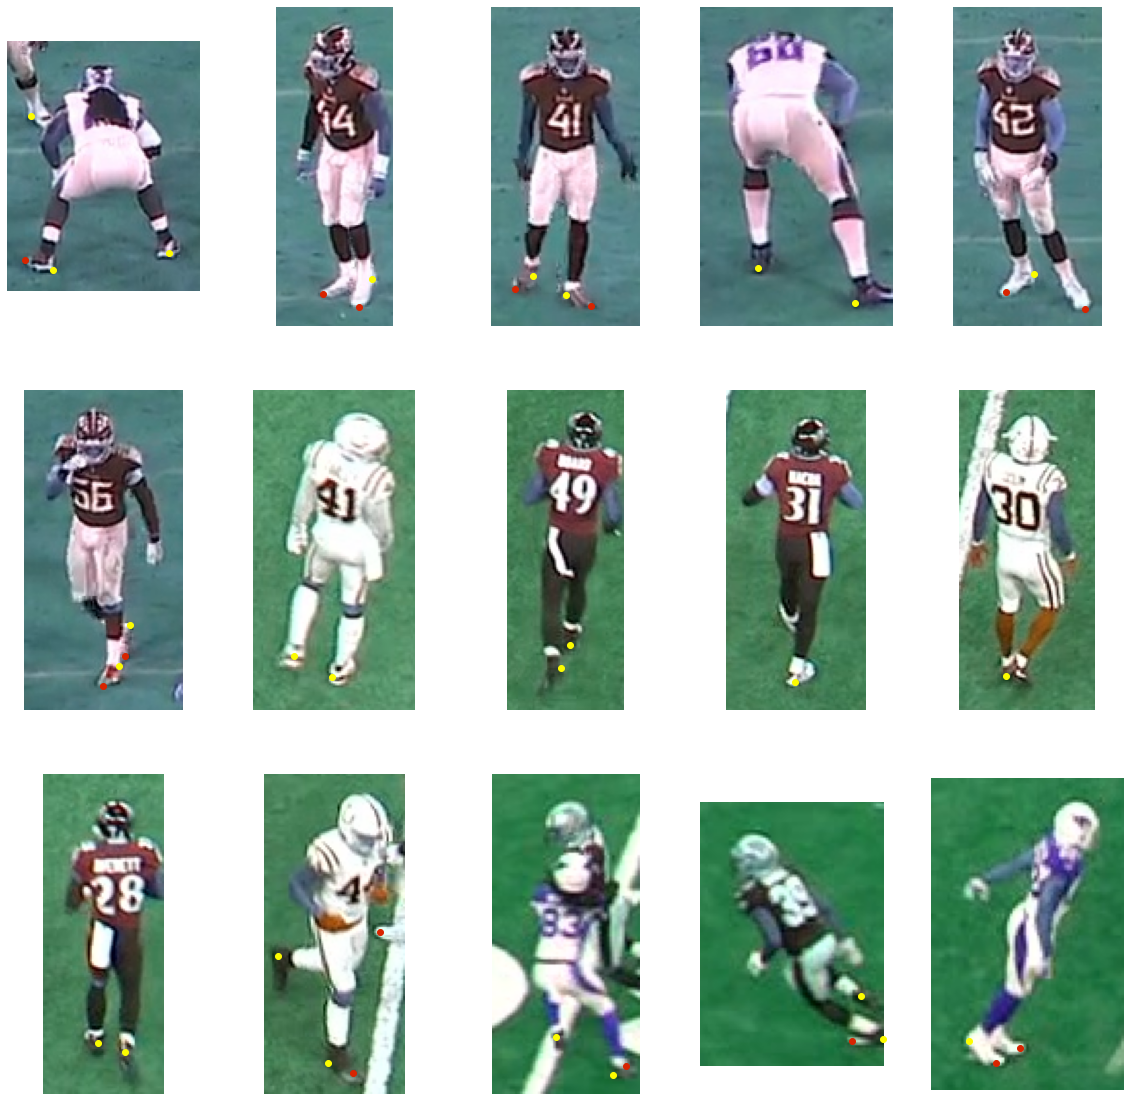

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np   

# Visualizing cropped images after YOLOv5
plt.figure(figsize=(20,20))
for num, x in enumerate(people_list[0:15]):
    image = x["image_data"]      
    img = Image.fromarray(image, 'RGB')
    plt.subplot(3,5,num+1)
    plt.axis('off')
    plt.imshow(img)
    for k in x["joints"]:
       plt.scatter(float(k[0]), float(k[1]),c=['#d82400' if k[3] == "toes" else '#fcfc00'])

In [ ]:
# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):

    for current_keypoint in keypoints:
        img = Image.fromarray(images, 'RGB')
        img.show()
 
images, keypoints = [], []

image = kps["image_data"]
keypoints = kps["joints"]

visualize_keypoints(image, keypoints)

In [ ]:
# original parameters
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5
NUM_KEYPOINTS = 4

In [ ]:
import progressbar
import cv2
target_size=(220,220)
resized_images=[]
resized_poses=[]
original_scale=[]
original_poses = []
poses=[x["joints"] for x in people_list]

# Resizing images
for idx,x in progressbar.progressbar(enumerate(people_list)):
    image = x["image_data"]
    height,width=image.shape[0],image.shape[1]
    scale_w,scale_h=target_size[0]/width,target_size[1]/height
    original_scale.append([width,height])
    temp_resize = []
    temp_og = []
    for j in range(len(poses[idx])):
      og_x = poses[idx][j][0]
      og_y = poses[idx][j][1]
      rescaled_x = og_x*scale_w
      rescaled_y = og_y*scale_h
      if poses[idx][j][3] == "toes":
        p_toe = 1
        p_heel = 0
      else:
        p_toe = 0
        p_heel = 1
      temp_og.append((og_x, og_y))
      temp_resize.append((rescaled_x / 220, rescaled_y / 220, p_toe, p_heel))
    

    resized_poses.append(temp_resize)
    original_poses.append(temp_og)
    
    
    image=cv2.resize(image,target_size,interpolation=cv2.INTER_AREA)
    resized_images.append(image)

resized_images=np.array(resized_images)
resized_poses=np.array(resized_poses)
original_scale=np.array(original_scale)

| |            #                                   | 4537 Elapsed Time: 0:00:01
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# classes per images up to 4 key points
classes = np.array([[p[3] for p in q] for q in poses])
classes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


array([list(['toes', 'heels', 'heels', 'heels']), list(['toes', 'toes', 'heels']), list(['toes', 'toes', 'heels', 'heels']), ..., list(['toes', 'toes', 'heels', 'toes']), list(['toes', 'toes']), list(['toes', 'toes'])], dtype=object)

In [ ]:
# Resized poses from 0 to 1 scale
resized_poses[0]

[(0.09063502019898513, 0.8721991384405839, 1, 0),
 (0.23166066122462617, 0.910028085809005, 0, 1),
 (0.8363615159254809, 0.8442386121247945, 0, 1),
 (0.11841279797676293, 0.29489650686163654, 0, 1)]

<Figure size 432x288 with 0 Axes>

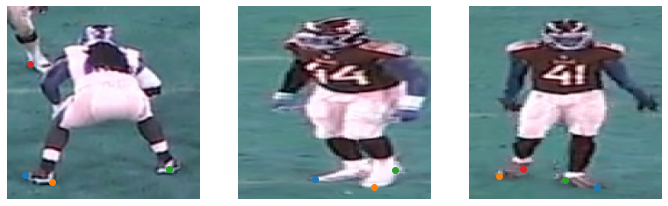

In [ ]:
%matplotlib inline
plt.clf()
plt.figure(figsize = (20, 20))

# Visualizing resized poses
for num, x in enumerate(resized_images[0:3]):
    img = Image.fromarray(x, 'RGB')
    plt.subplot(3, 5, num+1)
    plt.axis('off')
    plt.imshow(img)
    for w in range(len(resized_poses[num])):
      plt.scatter(float(resized_poses[num][w][0] * 220), float(resized_poses[num][w][1] * 220))

#### DeepPose

In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split
train_images, val_images, train_poses, val_poses = train_test_split(resized_images, resized_poses, test_size = 0.3, random_state = 822)

In [ ]:
resized_poses.shape

(4538,)

In [ ]:
val_poses.shape

(1362,)

In [ ]:
# for validation set pick the joints pick the images where are number of joints are equal to four

all_val_poses = []
index_list = []
for i, v_p in enumerate(val_poses):
  if len(v_p) == 4:
    all_val_poses.append(v_p)
    index_list.append(i)

all_val_poses = np.array(all_val_poses)

print(type(all_val_poses))
print(all_val_poses[0])

<class 'numpy.ndarray'>
[[    0.17036     0.86855           1           0]
 [     0.8429     0.82023           1           0]
 [    0.37459     0.89166           0           1]
 [    0.94149     0.79712           0           1]]


In [ ]:
all_val_images = []
for i in index_list:
  all_val_images.append(val_images[i])
all_val_images = np.array(all_val_images)
print(all_val_images.shape)

(517, 220, 220, 3)


#### Custom DeepPose Architecture

In [ ]:
from tensorflow.python.ops.control_flow_ops import while_loop_v2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import cv2
import scipy
import progressbar
import keras.backend as K

class DeepPoseModel():
  def __init__(self, train_images, train_poses, val_images, val_poses, training_config):
    self.train_images=train_images
    self.train_poses=np.array([np.array(t) for t in train_poses])
    self.val_images=list(val_images)
    self.val_poses = [np.array(v).reshape(16, 1) for v in val_poses]
    self.training_config=training_config

    self.model=self.define_model()
    print(self.model.summary())
    self.cascade_1=self.define_model(final_op=2)

    self.model.compile(optimizer=tf.keras.optimizers.Adam(training_config['Learning Rate']), loss=self.custom_loss, run_eagerly = True)

    if training_config['Train model'] == True:
      self.train_model()
  
  # cross entropy loss 
  def loss_class(self, y_true, y_pred):
    size = y_true.shape[0] * y_true.shape[1]
    y_true_reshape = tf.reshape(y_true, [size])
    y_pred_reshape = tf.reshape(y_pred, [-1])
    cce = tf.keras.losses.CategoricalCrossentropy()
    loss = cce(y_true_reshape, y_pred_reshape) / size
    return loss

  def loss_coord(self, y_true, y_pred, prob):
    resid = tf.sqrt(tf.reduce_sum(tf.multiply(prob, tf.square(y_true - y_pred))))
    return resid


  # custom mse loss weighted by probability values; multiply ground truth prob 
  # ground truth phat * log(p) = cross entropy 
  # final loss = weighted mse + cross entropy 
  def custom_loss(self, y_true, y_pred):
    x_coords = list(range(0, 16, 4))
    y_coords = list(range(1, 16, 4))
    prob_toe_idx = list(range(2, 16, 4))
    prob_heel_idx = list(range(3, 16, 4))

    prob_toe = tf.gather(y_true, indices=prob_toe_idx, axis = 1)
    prob_heel = tf.gather(y_true, indices = prob_heel_idx, axis = 1)
    probs = tf.add(prob_toe, prob_heel)

    coord_loss = self.loss_coord(tf.gather(y_true, indices = x_coords + y_coords, axis = 1), tf.gather(y_pred, indices = x_coords + y_coords, axis = 1), tf.tile(probs, [1, 2]))
    class_loss = self.loss_class(tf.gather(y_true, indices = prob_toe_idx, axis = 1), tf.gather(y_pred, indices = prob_toe_idx, axis = 1))
    return coord_loss + class_loss

  def save_model(self):
    self.checkpoint.save(file_prefix = self.checkpoint_prefix)
 
  def load_model(self):
    checkpoint_dir = '/content/gdrive/MyDrive/DS 6050: NFL Final Project'
    self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    self.checkpoint = tf.train.Checkpoint(model=self.model,cascade=self.cascade_1)
    self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  def to_relative_coord(self,coord,size):
    #Change pose scale to [-1, 1] scale
    return coord/size*2-1

  def to_absolute_coord(self,coord,size):
    #Change pose scale to scale on image size
    return (coord+1)/2*size

  def draw_pose(self,image_name):
    #Model draw pose on new image
    img=plt.imread(image_name)

    img_resized=cv2.resize(img,(220,220),interpolation=cv2.INTER_AREA)
    poses=self.model.predict(np.array([img_resized]))[0]
    poses_x,poses_y=poses[:14],poses[14:]
    poses_x=self.to_absolute_coord(poses_x,img.shape[1])
    poses_y=self.to_absolute_coord(poses_y,img.shape[0])

    plt.imshow(img)
    plt.scatter(poses_x,poses_y,c='r')
    plt.show()

  def augment_joints(self):
    for i in range(len(self.train_poses)):
      while len(self.train_poses[i]) < 4:
        random_joint = np.array((random.random(), random.random(), random.uniform(0, 0.1), random.uniform(0, 0.1)))
        self.train_poses[i] = np.append(self.train_poses[i], random_joint.reshape(1, 4), axis = 0)

  def train_model(self):
    val_dataset = tf.data.Dataset.from_tensor_slices((self.val_images, self.val_poses))
    val_dataset = val_dataset.batch(64)
    loss,val_loss=[],[]

    for epoch in range(self.training_config['Epochs']):
      print('Epoch',epoch+1)
      self.augment_joints()
      augmented_poses = self.train_poses.reshape(len(self.train_poses),-1)
      augmented_poses = np.array([a[0].reshape(16, 1) for a in augmented_poses])
      training_history=self.model.fit(x=self.train_images,y=augmented_poses,epochs=1,batch_size=128, validation_data=val_dataset)
      loss.append(training_history.history['loss'])
      val_loss.append(training_history.history['val_loss'])
    self.training_log={'loss':loss,'val_loss':val_loss}

  def custom_activation(self, input_t):
    sh = input_t.shape
    partial_sg = []
    for i in range(sh[1] // 2):
      partial_sg.append(K.sigmoid(input_t[:, i*2:(i+1)*2]))
    output = K.concatenate(partial_sg)
    return output
  
  def define_model(self,final_op=16):
    #Changes made on model architecture
    #LRN->BN, Pooling->Strided Convolution

    model=tf.keras.models.Sequential()

    model.add(tf.keras.layers.Rescaling(1./255, input_shape=(220, 220, 3)))

    model.add(tf.keras.layers.Conv2D(48,11,(4,4),padding='same',input_shape=(220,220,3)))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(128,5,(2,2),padding='same'))
    model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2D(192,3,(2,2),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))
    model.add(tf.keras.layers.Conv2D(192,3,(1,1),padding='same',activation='relu'))

    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(4096,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(4096,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(final_op,activation=self.custom_activation)) 
    
    return model

In [ ]:
with tf.device('/device:GPU:0'):
  DeepPose=DeepPoseModel(train_images, train_poses, all_val_images, all_val_poses, {'Train model':True,'Learning Rate':0.001,'Epochs':25})

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 220, 220, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 48)        17472     
                                                                 
 lambda (Lambda)             (None, 55, 55, 48)        0         
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 48)       192       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 55, 55, 48)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       153728    
                                                        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


                                                                 
 dense (Dense)               (None, 4096)              790528    
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 16)                65552     
                                                                 
Total params: 18,694,608
Trainable params: 18,694,256
Non-trainable params: 352
_________________________________________________________________
None
Epoch 1
25/25 [==============================] - 18s 288ms/step - loss: 9.1500 - val_loss: 8.3923
Epoch 2
25/25 [==========

In [ ]:
all_predictions = DeepPose.model.predict(all_val_images)
all_predictions = [p.reshape(4,4) for p in all_predictions]

In [ ]:
# Some predictions
all_predictions[0]

array([[    0.43489,      0.8575,     0.89955,     0.48587],
       [    0.59945,     0.83903,     0.50624,     0.52069],
       [    0.64795,     0.79019,    0.087815,     0.50062],
       [    0.69997,     0.69599,    0.092813,     0.51923]], dtype=float32)

In [ ]:
# Rescaling predictions
predictions = [p[:, 0:2] * 220 for p in all_predictions]

In [ ]:
label = [[1 if j[2] > j[3] else 0 for j in p] for p in all_predictions]
label[0:2]

[[1, 0, 0, 0], [1, 1, 0, 0]]

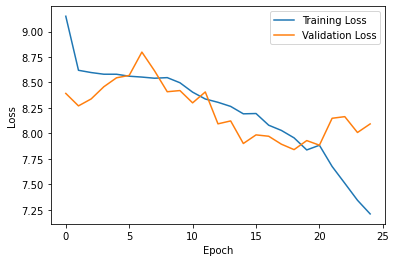

In [ ]:
# Visualizing Loss

plt.plot(DeepPose.training_log['loss'],label='Training Loss')
plt.plot(DeepPose.training_log['val_loss'],label='Validation Loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("/content/gdrive/MyDrive/DS 6050: NFL Final Project/loss_curve.png")
plt.show()

<Figure size 432x288 with 0 Axes>

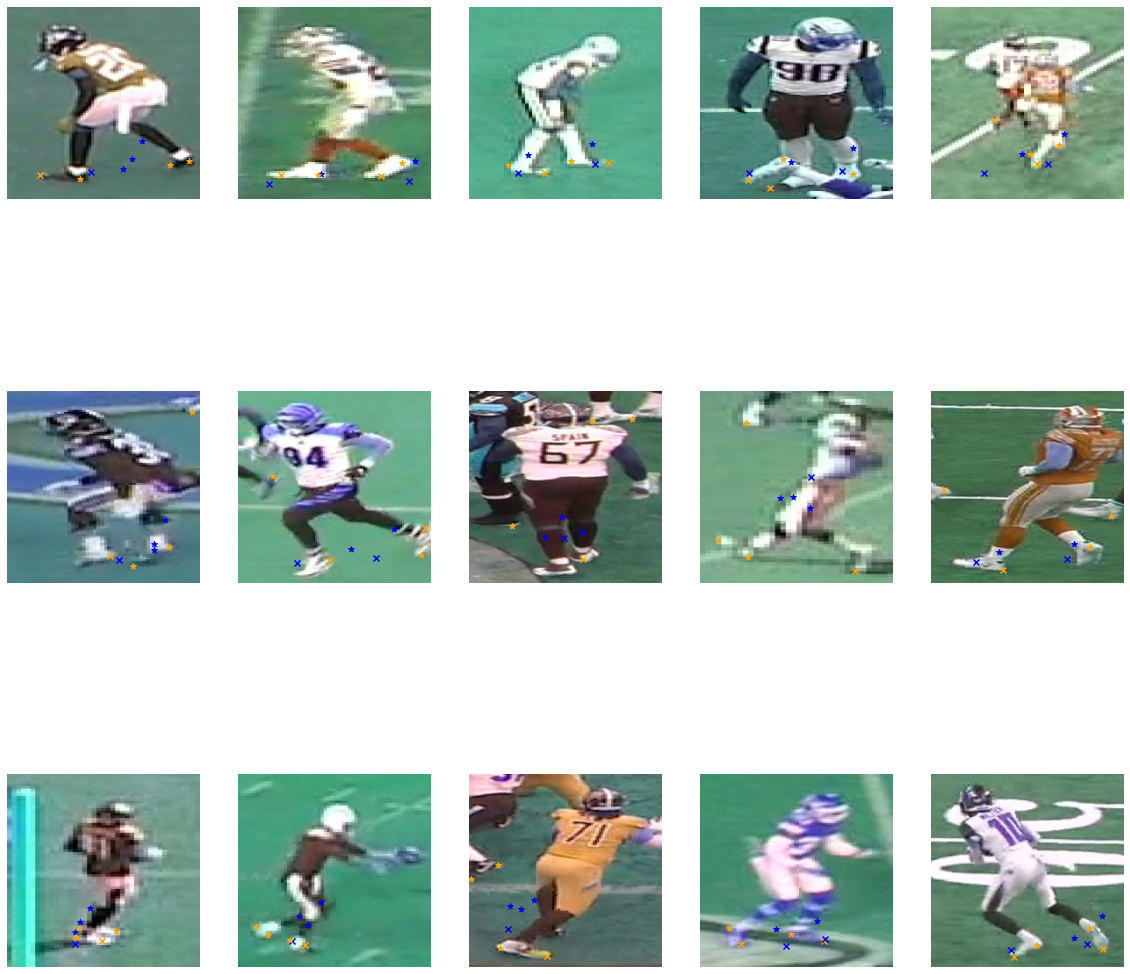

In [ ]:
%matplotlib inline
plt.clf()
plt.figure(figsize = (20, 20))

# Visualizing true and predicted key points
for num, x in enumerate(all_val_images[0:15]):
    img = Image.fromarray(x, 'RGB')
    plt.subplot(3, 5, num+1)
    plt.axis('off')
    plt.imshow(img)
    for w in range(len(all_val_poses[num])):
      plt.scatter(float(all_val_poses[num][w][0]) * 220, float(all_val_poses[num][w][1]) * 220, c="orange", marker=["x" if vc == 1 else "*" for vc in [label[num][w]]][0])
      plt.scatter(predictions[num][w][0], predictions[num][w][1], c="blue", marker=["x" if vc == 1 else "*" for vc in [label[num][w]]][0])
plt.savefig("/content/gdrive/MyDrive/DS 6050: NFL Final Project/final_output_predictions_w_marker.png")

In [ ]:
# Visualizing true and predicted key points for validation images not included in model training (less than 4 key points)

incomplete_joints_idx = [i for i in range(len(val_images)) if i not in index_list]
incomplete_predictions = DeepPose.model.predict(val_images[incomplete_joints_idx])

In [ ]:
incomplete_predictions = [p.reshape(4,4) for p in incomplete_predictions]

In [ ]:
incomplete_predictions[0]

array([[    0.33815,     0.78811,     0.83899,     0.49178],
       [     0.2641,     0.69158,     0.38857,     0.51866],
       [    0.39794,     0.66967,     0.16705,     0.49012],
       [    0.36126,     0.59701,     0.16506,     0.50145]], dtype=float32)

In [ ]:
predictions = [p[:, 0:2] * 220 for p in incomplete_predictions]
label = [[1 if j[2] > j[3] else 0 for j in p] for p in incomplete_predictions]
label[0:2]

[[1, 0, 0, 0], [1, 0, 0, 0]]

<Figure size 432x288 with 0 Axes>

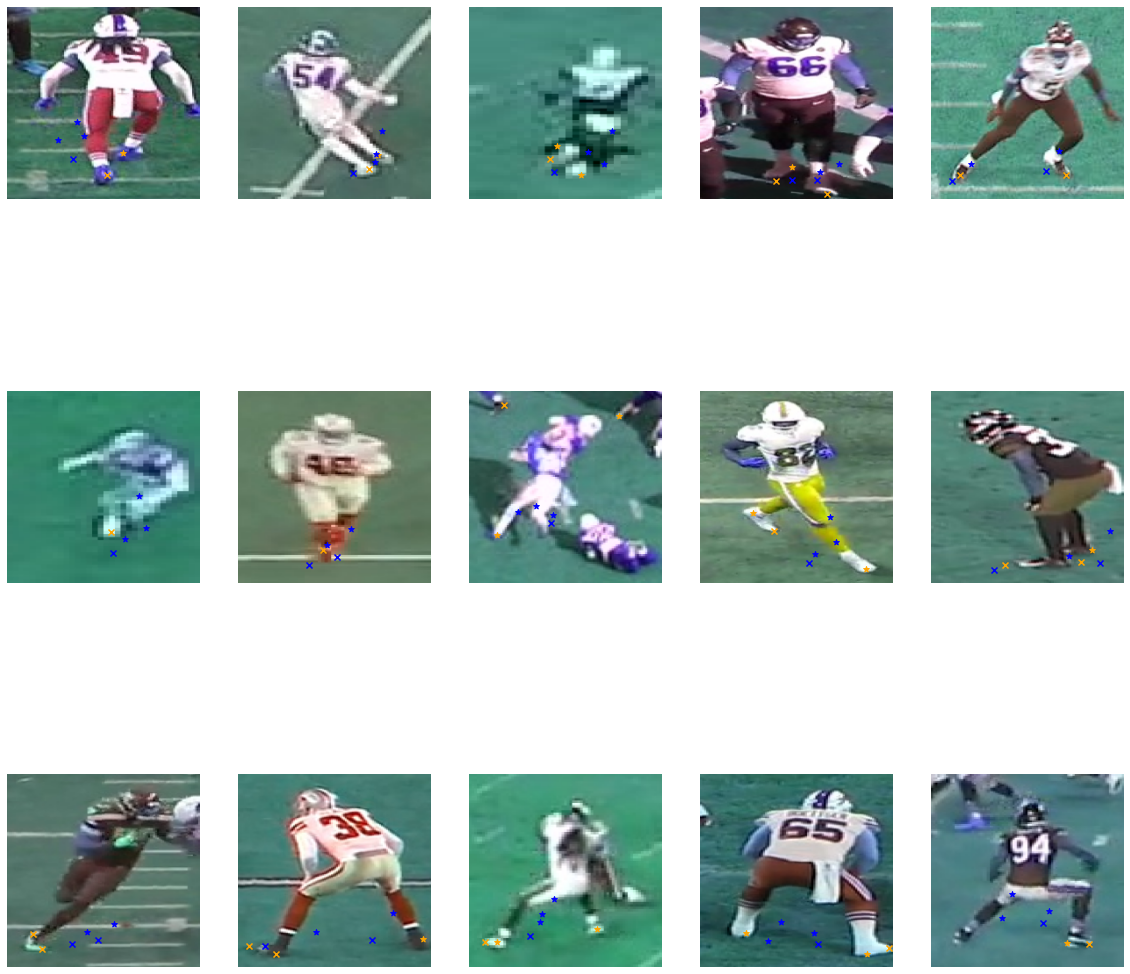

In [ ]:
%matplotlib inline
plt.clf()
plt.figure(figsize = (20, 20))
for num, x in enumerate(val_images[incomplete_joints_idx][0:15]):
    img = Image.fromarray(x, 'RGB')
    plt.subplot(3, 5, num+1)
    plt.axis('off')
    plt.imshow(img)
    for w in range(len(val_poses[incomplete_joints_idx][num])):
      plt.scatter(float(val_poses[incomplete_joints_idx][num][w][0]) * 220, float(val_poses[incomplete_joints_idx][num][w][1]) * 220, c="orange", marker=["x" if vc == 1 else "*" for vc in [label[num][w]]][0])
    for w in range(len(predictions[num])):
      plt.scatter(predictions[num][w][0], predictions[num][w][1], c="blue", marker=["x" if vc == 1 else "*" for vc in [label[num][w]]][0])
plt.savefig("/content/gdrive/MyDrive/DS 6050: NFL Final Project/final_output_predictions_w_marker_incomplete.png")